## Regime Detection using Hidden Markov Model (HMM)

We classify the market into 3 regimes:
- +1 : Uptrend
- 0  : Sideways
- -1 : Downtrend

Model: Gaussian HMM  
Training: First 70% of data  
Input Features: Options-based volatility and positioning features


In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    "../data/raw/nifty_features_5min.csv",
    parse_dates=["datetime"]
)

df.head()


,datetime,open_spot,high_spot,low_spot,close_spot,volume_spot,open_fut,high_fut,low_fut,close_fut,...,ema_15,spot_return,futures_basis,CE_oi,PE_oi,CE_vol,PE_vol,pcr_oi,pcr_volume,avg_iv
0,2024-01-01 09:20:00,20005.018928,20010.293137,20001.966296,20005.018928,126783,20012.663385,20019.639741,20012.403551,20012.663385,...,20005.922525,-0.000097,0.000382,4798571,4269134,67101,95953,0.889668,1.429979,0.148
1,2024-01-01 09:25:00,20014.090899,20016.924344,20008.144188,20014.090899,102965,20028.145999,20028.452187,20017.704173,20028.145999,...,20009.015874,0.000453,0.000702,4451123,4883450,77367,64703,1.097128,0.836313,0.180
2,2024-01-01 09:30:00,20035.439718,20038.655468,20022.815517,20035.439718,130099,20039.056747,20057.824216,20025.347076,20039.056747,...,20016.997589,0.001067,0.000181,3012383,4573190,93593,87459,1.518130,0.934461,0.188
3,2024-01-01 09:35:00,20032.156031,20049.522601,20012.706096,20032.156031,118317,20033.819226,20046.493694,20024.359496,20033.819226,...,20020.887632,-0.000164,0.000083,4890287,3790871,46101,77767,0.775184,1.686883,0.221
4,2024-01-01 09:40:00,20028.873112,20031.348242,20023.423903,20028.873112,107619,20043.319336,20061.483362,20042.139093,20043.319336,...,20022.698548,-0.000164,0.000721,3102051,3718832,99467,94739,1.198830,0.952467,0.194


In [5]:
features = df[[
    "avg_iv",
    "pcr_oi",
    "pcr_volume",
    "futures_basis",
    "spot_return"
]].dropna()

features.head()


,avg_iv,pcr_oi,pcr_volume,futures_basis,spot_return
0,0.148,0.889668,1.429979,0.000382,-0.000097
1,0.180,1.097128,0.836313,0.000702,0.000453
2,0.188,1.518130,0.934461,0.000181,0.001067
3,0.221,0.775184,1.686883,0.000083,-0.000164
4,0.194,1.198830,0.952467,0.000721,-0.000164


In [6]:
from hmmlearn.hmm import GaussianHMM

split = int(0.7 * len(features))
train_data = features.iloc[:split]

hmm = GaussianHMM(
    n_components=3,
    covariance_type="full",
    n_iter=100,
    random_state=42
)

hmm.fit(train_data)


,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [7]:
df = df.loc[features.index].copy()
df["raw_regime"] = hmm.predict(features)

df[["raw_regime"]].head()


,raw_regime
0,1
1,1
2,1
3,1
4,1


In [8]:
regime_returns = df.groupby("raw_regime")["spot_return"].mean()

bull = regime_returns.idxmax()
bear = regime_returns.idxmin()

df["regime"] = df["raw_regime"].map(
    lambda x: 1 if x == bull else (-1 if x == bear else 0)
)

df["regime"].value_counts()


regime
 0    27682
 1       52
-1        5
Name: count, dtype: int64

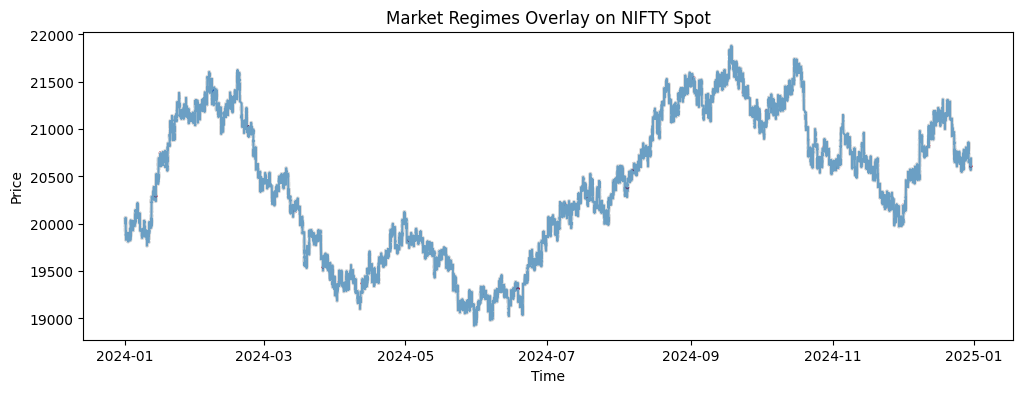

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df["datetime"], df["close_spot"], label="NIFTY Spot", alpha=0.6)

plt.scatter(
    df["datetime"],
    df["close_spot"],
    c=df["regime"],
    cmap="coolwarm",
    s=3
)

plt.title("Market Regimes Overlay on NIFTY Spot")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


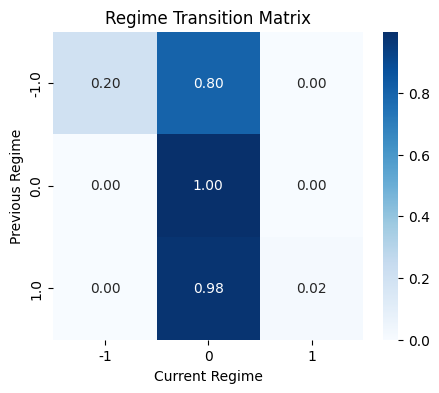

In [10]:
import seaborn as sns

transition_matrix = pd.crosstab(
    df["regime"].shift(1),
    df["regime"],
    normalize="index"
)

plt.figure(figsize=(5,4))
sns.heatmap(
    transition_matrix,
    annot=True,
    cmap="Blues",
    fmt=".2f"
)
plt.title("Regime Transition Matrix")
plt.xlabel("Current Regime")
plt.ylabel("Previous Regime")
plt.show()


In [11]:
regime_stats = df.groupby("regime")[[
    "avg_iv",
    "pcr_oi",
    "pcr_volume",
    "spot_return"
]].agg(["mean", "std"])

regime_stats


avg_iv              pcr_oi           pcr_volume            \
            mean       std      mean       std       mean       std   
regime                                                                
-1      0.147200  0.026818  1.905327  0.119429   0.961351  0.180689   
 0      0.180274  0.029237  1.015852  0.189868   1.028794  0.259331   
 1      0.185154  0.033713  1.107749  0.195321   2.284357  0.177820   

       spot_return            
              mean       std  
regime                        
-1       -0.000079  0.000440  
 0        0.000001  0.000699  
 1        0.000106  0.000615

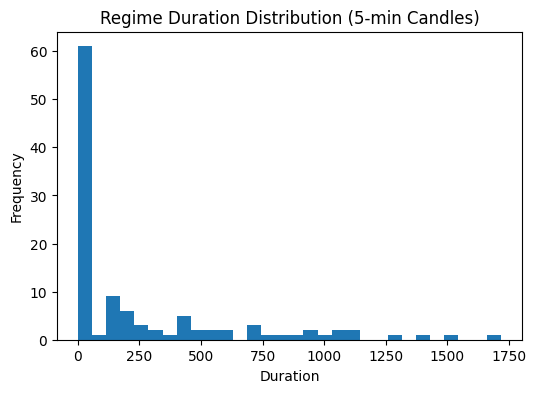

In [12]:
df["regime_change"] = df["regime"] != df["regime"].shift(1)
df["regime_block"] = df["regime_change"].cumsum()

durations = df.groupby("regime_block").size()

plt.figure(figsize=(6,4))
plt.hist(durations, bins=30)
plt.title("Regime Duration Distribution (5-min Candles)")
plt.xlabel("Duration")
plt.ylabel("Frequency")
plt.show()


In [13]:
df.to_csv("../data/nifty_with_regimes_5min.csv", index=False)
